# Deep Learning kaggle comp
- `Lat_Dec`: Observed Latitude in decimal degrees
- `Lon_Dec`: Observed Longitude in decimal degrees
- `NO2uM`: Micromoles Nitrite per liter of seawater
- `NO3uM`: Micromoles Nitrate per liter of seawater
- `NH3uM`: Micromoles Ammonia per liter of seawater
- `R_TEMP`: Reported (Potential) Temperature in degrees Celsius
- `R_Depth`: Reported Depth (from pressure) in meters
- `R_Sal`: Reported Salinity (from Specific Volume Anomoly, M³/Kg)
- `R_DYNHT`: Reported Dynamic Height in units of dynamic meters (work per unit mass)
- `R_Nuts`: Reported Ammonium concentration
- `R_Oxy_micromol.Kg`: Reported Oxygen micromoles/kilogram
- `PO4uM`: Micromoles Phosphate per liter of seawater
- `SiO3uM`: Micromoles Silicate per liter of seawater
- `TA1.x`: Total Alkalinity micromoles per kilogram solution
- `Salinity1`: Salinity (Practical Salinity Scale 1978)
- `Temperature_degC`: Water temperature in degrees Celsius
- `DIC`: Dissolved Inorganic Carbon micromoles per kilogram solution

In [1]:
# Basic libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
import time

# Deep learning libraries
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, randint
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Import data
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
sample_sub =  pd.read_csv("data/sample_submission.csv")

# Remove NA column from training data
train_df = train_df.drop(columns='Unnamed: 12')

# Fix column names error in test_df
test_df = test_df.rename(columns={'TA1':'TA1.x'})

2025-03-19 17:30:17.246760: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-19 17:30:17.287799: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-19 17:30:17.287830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-19 17:30:17.289134: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 17:30:17.296377: I tensorflow/core/platform/cpu_feature_guar

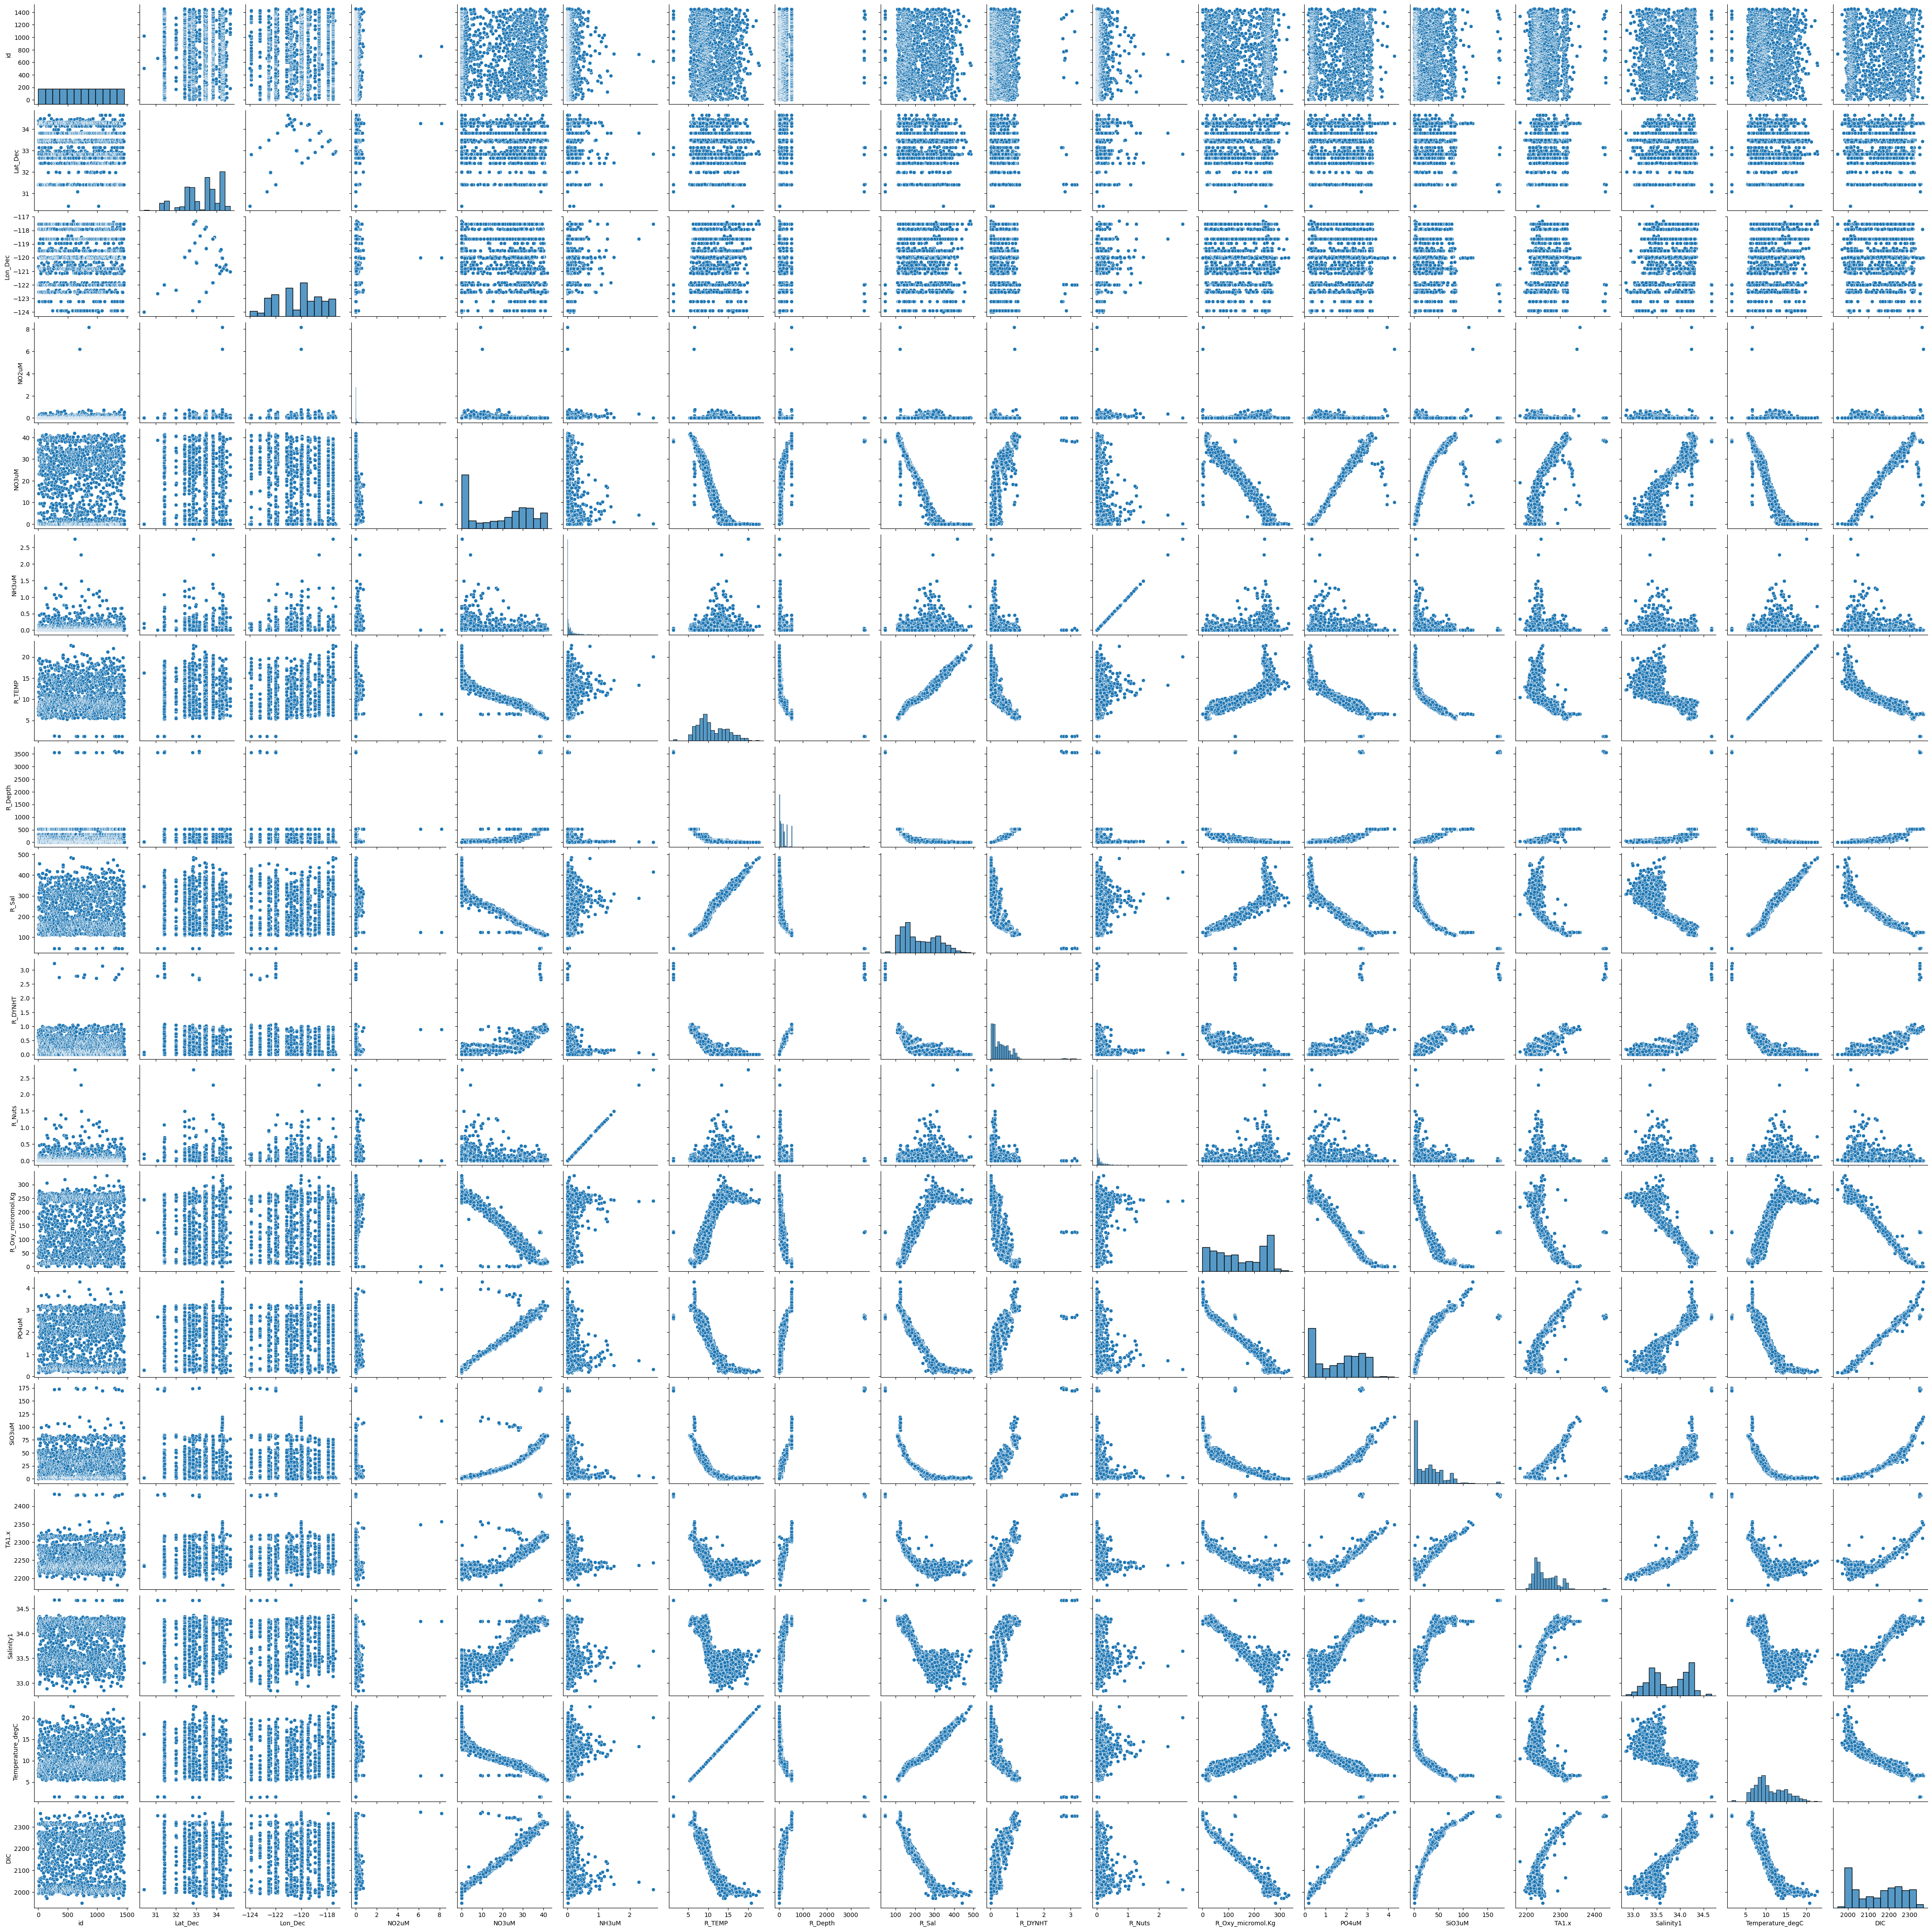

<Figure size 640x480 with 0 Axes>

In [2]:
sns.pairplot(train_df)
plt.show()
plt.savefig('pairplot.png')

In [ ]:
# Fit an OLS Regression Model
# ols_model = LinearRegression()
# ols_model.fit(x, y)

# # Print OLS coefficients
# print(f"OLS Coefficients: Intercept = {ols_model.intercept_[0]}, Slope = {ols_model.coef_[0][0]}")
# print(f"OLS Standard Deviation (Residual Error): {np.sqrt(mean_squared_error(y, ols_model.predict(x)))}")

In [3]:
# Assign features
X = train_df.drop(columns='DIC')
y = train_df['DIC']

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=808) 

# Scale the data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X.columns)

In [4]:
# Convert data to NumPy arrays (if not already)
X_train_dl = np.array(X_train_scaled)
X_val_dl = np.array(X_val_scaled)
y_train_dl = np.array(y_train)
y_val_dl = np.array(y_val)

In [5]:
# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_dl.shape[1],)),  # Input layer
    Dropout(0.2),  # Prevent overfitting
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer (no activation for regression)
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.01),  # Can tune this later
    loss='mse',  # Minimize MSE
    metrics=[tf.keras.metrics.RootMeanSquaredError()]  # RMSE as a metric
)

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2304      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12673 (49.50 KB)
Trainable params: 12673 (49.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# Set early stopping to monitor validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs=200,  # Can be increased
    batch_size=32,  # Adjust based on dataset size
    callbacks=[early_stopping],  # Stop if overfitting
    verbose=1
)

Epoch 1/200
32/32 [==============================] - 1s 10ms/step - loss: 2882730.7500 - root_mean_squared_error: 1697.8606 - val_loss: 717080.2500 - val_root_mean_squared_error: 846.8059
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 379493.8438 - root_mean_squared_error: 616.0307 - val_loss: 164367.8750 - val_root_mean_squared_error: 405.4231
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 106208.5625 - root_mean_squared_error: 325.8965 - val_loss: 59486.6836 - val_root_mean_squared_error: 243.8989
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 58631.4844 - root_mean_squared_error: 242.1394 - val_loss: 39306.6680 - val_root_mean_squared_error: 198.2591
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 44173.9531 - root_mean_squared_error: 210.1760 - val_loss: 27749.3887 - val_root_mean_squared_error: 166.5815
Epoch 6/200
32/32 [==============================] - 0s 6ms/step - loss: 3921

In [9]:
# Evaluate the model
val_loss, val_rmse = model.evaluate(X_val_dl, y_val_dl, verbose=0)

print(f"Validation RMSE: {val_rmse:.4f}")

Validation RMSE: 32.5178


In [ ]:
# Make predictions
y_pred_dl = model.predict(X_val_dl)

# Compute RMSE manually
rmse = np.sqrt(mean_squared_error(y_val_dl, y_pred_dl))
print(f"Final RMSE: {rmse:.4f}")

14/14 [==============================] - 0s 1ms/step
Final RMSE: 32.5178
